<a href="https://colab.research.google.com/github/BiniyamAschalew/BiniyamAschalew/blob/main/sub72organized343.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('content')
input_dir = "content/MyDrive/IE343/"

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [ ]:
from google.colab import files

In [ ]:
# !pip install optuna
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  HistGradientBoostingRegressor,RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, KFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import re
import geopandas as gpd
# import optuna
# from optuna.integration import XGBoostPruningCallback

In [ ]:
from scipy.spatial import distance
from sklearn.neighbors import BallTree

In [ ]:
train_data = pd.read_csv(input_dir + "train.csv")
test_data = pd.read_csv(input_dir + "test.csv")
seoul_subway0 = pd.read_csv(input_dir + "Seoul_subway_stations.csv")
busan_subway0 = gpd.read_file(input_dir + 'Shape_files/Busan_subway.shp').to_crs(epsg=4326)

In [ ]:
seoul_subway = seoul_subway0[['lat', 'lng']]
seoul_subway.rename(columns={'lng':'long'}, inplace=True)
seoul_subway

<ipython-input-167-67fb2af9d7c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seoul_subway.rename(columns={'lng':'long'}, inplace=True)


,lat,long
0,37.948100,127.061034
1,37.927878,127.054790
2,37.913702,127.057277
3,37.901885,127.056482
4,37.892334,127.055716
...,...,...
704,37.317185,127.404760
705,37.265579,127.442260
706,37.260192,127.490277
707,37.295309,127.570938


In [ ]:
# preprocessing

busan_subway = busan_subway0['geometry'].apply(lambda x: x.coords[0][::-1]).tolist()
busan_subway = pd.DataFrame(busan_subway, columns=['lat', 'long'])
busan_subway

,lat,long
0,35.169101,128.950703
1,35.163607,128.956957
2,35.160308,128.979736
3,35.179178,128.956271
4,35.193403,128.965648
...,...,...
114,35.096974,128.985480
115,35.100812,128.975726
116,35.103371,128.969096
117,35.092484,128.962904


In [ ]:
subway = pd.concat([busan_subway, seoul_subway], ignore_index=True)
subway

,lat,long
0,35.169101,128.950703
1,35.163607,128.956957
2,35.160308,128.979736
3,35.179178,128.956271
4,35.193403,128.965648
...,...,...
823,37.317185,127.404760
824,37.265579,127.442260
825,37.260192,127.490277
826,37.295309,127.570938


In [ ]:
tr = train_data.copy()
tst = test_data.copy()

In [ ]:
# change the columns with object dtype to numbers by encoding them
le = LabelEncoder()
label_columns = list(tr.select_dtypes('object'))
for col in label_columns:
  le.fit(tr[col])
  tr[col] = le.transform(tr[col])
  tst[col] = le.transform(tst[col])

In [ ]:
min_year = tr['transaction_year'].min()
tr['cpi'] = (tr['transaction_year'] - min_year) * 12 + tr['transaction_month']
tr['age'] = tr['transaction_year'] - tr['built_year']

tst['cpi'] = (tst['transaction_year'] - min_year) * 12 + tst['transaction_month']
tst['age'] = tst['transaction_year'] - tst['built_year']

tr.head()
tr.dtypes

index                  int64
apartment_id           int64
city                   int64
dong                   int64
house_area           float64
built_year             int64
floor                  int64
lat                  float64
long                 float64
transaction_year       int64
transaction_month      int64
transaction_day        int64
PRICE                float64
cpi                    int64
age                    int64
dtype: object

In [ ]:
# see the effect at the end

# scale lat and long
# scaler_lat = StandardScaler()
# scaler_long = StandardScaler()

# # tr.loc[tr['dong'] != 113,'lat'] = scaler_lat.fit_transform(tr[tr['dong'] != 113]['lat'])
# scaler_lat.fit(tr[tr['dong'] != 113][['lat']])
# tr.loc[tr['dong'] != 113, 'lat'] = scaler_lat.transform(tr[tr['dong'] != 113][['lat']])
# tst.loc[tst['dong'] != 113, 'lat'] = scaler_lat.transform(tst[tst['dong'] != 113][['lat']])

# scaler_long.fit(tr[tr['dong'] != 113][['long']])
# tr.loc[tr['dong'] != 113, 'long'] = scaler_long.transform(tr[tr['dong'] != 113][['long']])
# tst.loc[tst['dong'] != 113, 'long'] = scaler_long.transform(tst[tst['dong'] != 113][['long']])

# tr.loc[:, 'lat'].mean()

In [ ]:
# Taking care of missing values
# the only missing values exist in busan dong 113
# solution lets assign its values with normal distribution with mean -> average of all lat and long in busan, sd of sd of the others
busan_dong_train = tr[tr['city'] == 0].loc[:, ["dong", "lat", "long"]]
busan_dong_test = tst[tst['city'] == 0].loc[:, ["dong", "lat", "long"]]
busan_dong = pd.concat([busan_dong_train, busan_dong_test])

mean_lat1, mean_long1 = busan_dong[busan_dong['dong'] == 115].mean()[1:]
mean_lat2, mean_long2 = busan_dong[busan_dong['dong'] == 114].mean()[1:]
mean_lat = (mean_lat1 + mean_lat2)/2
mean_long = (mean_long1 + mean_long2)/2
mean_lat, mean_long

std_lat1, std_long1 = busan_dong[busan_dong['dong'] == 115].std()[1:]
std_lat2, std_long2 = busan_dong[busan_dong['dong'] == 114].std()[1:]
std_lat = (std_lat1 + std_lat2)/2
std_long = (std_long1 + std_long2)/2
std_lat, std_long

na_train = 89
na_test = 13


# busan_dong.head()


In [ ]:
# now let's scale lat and long to have standard normal dist


In [ ]:

tst.loc[tst['dong'] == 113,'lat'] = np.random.randn(na_test) * std_lat + mean_lat
tst.loc[tst['dong'] == 113,'long'] = np.random.randn(na_test) * std_long + mean_long

tr.loc[tr['dong'] == 113,'lat'] = np.random.randn(na_train) * std_lat + mean_lat
tr.loc[tr['dong'] == 113,'long'] = np.random.randn(na_train) * std_long + mean_long

In [ ]:
# since the apartment id is random hash name of apartments, lets converted it to also represent the average price of that apartment frenchise

tr['apartment_rank'] = np.zeros(len(tr))
tst['apartment_rank'] = np.zeros(len(tst))


apartment_price = tr.groupby('apartment_id')['PRICE'].agg('mean').sort_values(ascending=False)
apartment_price # I want to sort them and put the sorted
for idx, apartment in enumerate(list(apartment_price.index)):
  tr.loc[tr['apartment_id'] == apartment, 'apartment_rank' ] = idx
  tst.loc[tst['apartment_id'] == apartment, 'apartment_rank' ] = idx

# sns.regplot(x=tr['apartment_rank'], y = tr['PRICE'])

In [ ]:
# add distance to subway stations as a feature
homes_rad_tr = np.radians(tr[['lat', 'long']])
homes_rad_tst = np.radians(tst[['lat', 'long']])
subway_rad = np.radians(subway)

tree = BallTree(subway_rad, metric='haversine')

distance_tr, indices_tr = tree.query(homes_rad_tr, k=3)
distance_tst, indices_tst = tree.query(homes_rad_tst, k = 3)

distance_tr *= 6371
distance_tst *= 6371

distance_tr3 = distance_tr.sum(axis=1)
distance_tst3 = distance_tst.sum(axis=1)

In [ ]:
distance_tr1 = distance_tr.min(axis=1)
distance_tst1 = distance_tst.min(axis=1)



In [ ]:
# add the sum of the distance to the nearest 3 subways and the min distance to a subway to the featuer set
tr['dist1'] = distance_tr1
tr['dist3'] = distance_tr3

tst['dist1'] = distance_tst1
tst['dist3'] = distance_tst3

tr

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE,cpi,age,apartment_rank,dist1,dist3
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,7,0,229250.80,43,28,3180.0,0.267518,2.206177
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,10,1,215320.00,46,28,3180.0,0.267518,2.206177
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,3,5,161740.00,27,27,3180.0,0.267518,2.206177
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,5,0,199781.80,29,27,3180.0,0.267518,2.206177
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,6,4,219606.40,54,29,3180.0,0.267518,2.206177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,329685,4419,1,37,101.431912,2014,4,37.452039,127.070842,2022,5,5,885070.00,53,8,396.0,1.443422,8.650589
329686,329686,4419,1,37,101.431912,2014,14,37.452039,127.070842,2021,10,1,826132.00,46,7,396.0,1.443422,8.650589
329687,329687,4419,1,37,71.687641,2014,2,37.452039,127.070842,2022,11,4,697540.00,59,8,396.0,1.443422,8.650589
329688,329688,4419,1,37,137.192013,2014,18,37.452039,127.070842,2020,9,4,870656.98,33,6,396.0,1.443422,8.650589


In [ ]:
x_train2 = tr.copy()
x_test2 = tst.copy()

finx_train = x_train2.drop(columns = 'PRICE')
finy_train = x_train2['PRICE']
x_test2

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,cpi,age,apartment_rank,dist1,dist3
0,329690,0,0,197,101.647190,1993,3,35.149929,129.006071,2023,1,5,61,30,3180.0,0.267518,2.206177
1,329691,0,0,197,91.511175,1993,12,35.149929,129.006071,2023,2,1,62,30,3180.0,0.267518,2.206177
2,329692,0,0,197,125.865988,1993,2,35.149929,129.006071,2023,2,0,62,30,3180.0,0.267518,2.206177
3,329693,0,0,197,101.647190,1993,8,35.149929,129.006071,2023,2,2,62,30,3180.0,0.267518,2.206177
4,329694,0,0,197,101.647190,1993,13,35.149929,129.006071,2023,3,5,63,30,3180.0,0.267518,2.206177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,10,5,70,9,396.0,1.443422,8.650589
85093,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,10,5,70,9,396.0,1.443422,8.650589
85094,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,11,1,71,9,396.0,1.443422,8.650589
85095,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,11,4,71,9,396.0,1.443422,8.650589


In [ ]:
x_test2.columns

Index(['index', 'apartment_id', 'city', 'dong', 'house_area', 'built_year',
       'floor', 'lat', 'long', 'transaction_year', 'transaction_month',
       'transaction_day', 'cpi', 'age', 'apartment_rank', 'dist1', 'dist3'],
      dtype='object')

In [ ]:
model_lgb8 = lgb.LGBMRegressor( n_estimators = 10000)
model_lgb8.fit(finx_train, finy_train)

y_pred8 = model_lgb8.predict(x_test2)

output = pd.concat([x_test2['index'], pd.DataFrame(y_pred8, columns = ["PRICE"])], axis = 1)

output.to_csv('subm11.csv', index=False)  
files.download('subm11.csv')
# subm10 with n_est -= 20 k and subway data returned 48k
# and with 10k I got 47.6k , it increased with the subway data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [341]:
from sklearn.decomposition import PCA, FastICA

x_test3 = x_test2.copy()
x_train3 = x_train2.copy()

park = pd.read_csv(input_dir + 'park.csv')
day_care = pd.read_csv(input_dir + 'day_care_center.csv')

day_care.isna().any(axis=0)
# park.d
# I am going to add the number of parks and children center


city                    False
gu                      False
day_care_name           False
day_care_type           False
day_care_baby_num       False
teacher_num              True
nursing_room_num         True
playground_num           True
CCTV_num                 True
is_commuting_vehicle     True
dtype: bool

In [ ]:
day_care.columns

Index(['city', 'gu', 'day_care_name', 'day_care_type', 'day_care_baby_num',
       'teacher_num', 'nursing_room_num', 'playground_num', 'CCTV_num',
       'is_commuting_vehicle'],
      dtype='object')

In [ ]:
day_care["day_care_type"].unique()

array(['national/public', 'home', 'private', 'workplace',
       'social welfare organization', 'corporate', 'cooperation'],
      dtype=object)

In [ ]:
len(day_care)

7373

In [342]:
# day_care.info() # I can calculate student, teacher ratio
pk = park.copy()
d_care = day_care.copy()
d_care
# for each city and gu, count the number of private/ welfare daycare types, student to teacher ratio and add that to the park info

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle
0,seoul,2,019dlft759nepobxqft2,national/public,49,9.0,NaN,NaN,NaN,
1,seoul,31,029xz1jtrlpcf9u5sq3i,home,20,4.0,4.0,0.0,0.0,N
2,seoul,3,02e04o0l2br7swfds7jn,private,49,9.0,NaN,NaN,NaN,Y
3,seoul,3,02e04o0l2br7swfds7jn,private,49,9.0,NaN,NaN,NaN,Y
4,busan,14,02e04o0l2br7swfds7jn,home,20,6.0,4.0,0.0,4.0,Y
...,...,...,...,...,...,...,...,...,...,...
7368,seoul,26,zzmuzxowbztizec6dj11,private,28,6.0,NaN,NaN,5.0,N
7369,seoul,3,zzqq55uk81jpkvnrrbni,private,73,11.0,NaN,NaN,NaN,Y
7370,busan,19,zzqq55uk81jpkvnrrbni,home,20,6.0,3.0,0.0,4.0,Y
7371,seoul,3,zzqq55uk81jpkvnrrbni,private,73,11.0,NaN,NaN,NaN,Y


In [343]:
# first fill the na values for teacher_num
# d_care[(d_care['gu'] == 10) & (d_care["day_care_type"] == 'national/public') & (d_care["day_care_baby_num"] >=  28) & (d_care["day_care_baby_num"] <=  40)]
# fill them out with gaussian
nt_mean = d_care[d_care["teacher_num"].notna()].mean()["teacher_num"]
nt_std = d_care[d_care["teacher_num"].notna()].std()["teacher_num"]

nt_num = d_care["teacher_num"].isna().sum()
rand_list = np.random.randn(nt_num) * nt_mean + nt_std
d_care.loc[d_care["teacher_num"].isna(), "teacher_num"] = rand_list
d_care['day_care_type'].unique()

<ipython-input-343-aecd30a87f49>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  nt_mean = d_care[d_care["teacher_num"].notna()].mean()["teacher_num"]
<ipython-input-343-aecd30a87f49>:5: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  nt_std = d_care[d_care["teacher_num"].notna()].std()["teacher_num"]


array(['national/public', 'home', 'private', 'workplace',
       'social welfare organization', 'corporate', 'cooperation'],
      dtype=object)

In [344]:
mapping = {
    'private':10,
    'corporate':8,
    'workplace':7,
    'home':6,
    'cooperation':6,
    'national/public':3,
    'social welfare organization':0
}
d_care['type_score'] = d_care['day_care_type'].map(mapping)
d_care['TSratio'] = d_care['teacher_num']/d_care['day_care_baby_num']
# compte the total important features per gu
fd_care = d_care.loc[:, ['city', 'gu', 'day_care_baby_num', 'type_score', 'TSratio']]
grouped_fd = fd_care.groupby(['city', 'gu']).agg({'day_care_baby_num':'sum','type_score':'sum','TSratio':'sum'}).reset_index()
grouped_fd.rename(columns = {'type_score': 'DC_score', 'TSratio': "DC_ratio"}, inplace=True)
grouped_fd.head()

,city,gu,day_care_baby_num,DC_score,DC_ratio
0,busan,3,5312,835,28.728521
1,busan,7,5251,813,24.089393
2,busan,9,6676,996,30.994660
3,busan,12,2214,250,7.847675
4,busan,14,6293,920,27.159390


In [345]:
# imp_park = park.drop(labels=["park_name"])
park['park_name']
park2 = park.drop(labels=['park_name'], axis=1)
park2['park_type'] = pd.factorize(park2['park_type'])[0]
park2.drop(labels=['park_open_year'], axis = 1,inplace=True)
park2['park_num'] = np.ones(len(park2))
park2 = park2.groupby(['city', 'gu', 'dong']).agg({'park_type':'mean', 'park_area':'sum', 'park_num':'sum'}).reset_index()
# park2
# grouped_fd 

In [346]:
park_DC = park2.merge(grouped_fd, on=['city', 'gu'])
park_DC.head()
park_DC['city'] = pd.factorize(park_DC['city'])[0]
park_DC.head()

,city,gu,dong,park_type,park_area,park_num,day_care_baby_num,DC_score,DC_ratio
0,0,3,41,1.00,110.507466,1.0,5312,835,28.728521
1,0,3,52,3.00,25.416530,1.0,5312,835,28.728521
2,0,3,78,0.64,1941.754346,25.0,5312,835,28.728521
3,0,3,120,1.00,339.237872,2.0,5312,835,28.728521
4,0,3,142,0.50,403.569523,4.0,5312,835,28.728521


In [395]:
park_DC_unique = park_DC.drop_duplicates(subset=['city', 'dong'])
x_train3 = x_train2.merge(park_DC_unique, on=['city', 'dong'], how='left')
x_test3 = x_test2.merge(park_DC_unique, on=['city', 'dong'], how='left')

# x_test3

In [375]:
# for subm003 I am remvoing the index from x_train

X_test

,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,...,apartment_rank,dist1,dist3,gu,park_type,park_area,park_num,day_care_baby_num,DC_score,DC_ratio
0,0,0,197,101.647190,1993,3,35.149929,129.006071,2023,1,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
1,0,0,197,91.511175,1993,12,35.149929,129.006071,2023,2,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
2,0,0,197,125.865988,1993,2,35.149929,129.006071,2023,2,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
3,0,0,197,101.647190,1993,8,35.149929,129.006071,2023,2,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
4,0,0,197,101.647190,1993,13,35.149929,129.006071,2023,3,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,10,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329
85093,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,10,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329
85094,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,11,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329
85095,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,11,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329


In [349]:
# model_lgb11 = lgb.LGBMRegressor( n_estimators = 20000)
# model_lgb11.fit(finx_train3, finy_train3)
# x_train2

Index(['apartment_id', 'city', 'dong', 'house_area', 'built_year', 'floor',
       'lat', 'long', 'transaction_year', 'transaction_month',
       'transaction_day', 'cpi', 'age', 'apartment_rank', 'dist1', 'dist3',
       'gu', 'park_type', 'park_area', 'park_num', 'day_care_baby_num',
       'DC_score', 'DC_ratio'],
      dtype='object')

In [414]:
# applying pca to the least important features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_test3.head()
selected_features_tr = x_train3[['park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3',
       'gu', 'park_type','park_area', 'dist1']]
selected_features_tst = x_test3[['park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3',
       'gu', 'park_type','park_area', 'dist1']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features_tr)
pca = PCA(n_components=2)
pc_tr = pca.fit_transform(selected_features_tr)
pc_tst = pca.transform(selected_features_tst)


In [415]:
# to get the feature importance, 
# trial 5 , pca applied
X_train = x_train3.drop(columns = ['PRICE', 'index','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3','gu', 'park_type', 'park_area', 'dist1' ])
Y_train = x_train3['PRICE']
X_test = x_test3.drop(columns = ['index','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3','gu', 'park_type','park_area', 'dist1'  ])

train_principal = pd.DataFrame(data = pc_tr, columns = ['pc1', 'pc2'])

test_principal = pd.DataFrame(data = pc_tst, columns = ['pc1', 'pc2'])


In [429]:
test_principal
X_test2 = X_test.join(test_principal)
X_train2= X_train.join(train_principal)
# train_principal.isna().sum()
# X_train.isna().sum()

In [437]:
X_train.columns

Index(['apartment_id', 'dong', 'house_area', 'built_year', 'floor', 'lat',
       'long', 'transaction_month', 'transaction_day', 'cpi', 'age',
       'apartment_rank'],
      dtype='object')

In [438]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


selected_features_tr = x_train3[['lat','long', 'dong','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3',
       'gu', 'park_type','park_area', 'dist1']]
selected_features_tst = x_test3[['lat','long', 'dong','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3',
       'gu', 'park_type','park_area', 'dist1']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features_tr)
pca = PCA(n_components=3)
pc_tr = pca.fit_transform(selected_features_tr)
pc_tst = pca.transform(selected_features_tst)


X_train = x_train3.drop(columns = ['lat','long', 'dong','PRICE', 'index','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3','gu', 'park_type', 'park_area', 'dist1' ])
Y_train = x_train3['PRICE']
X_test = x_test3.drop(columns = ['lat','long', 'dong','index','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city', 'dist3','gu', 'park_type','park_area', 'dist1'  ])

train_principal = pd.DataFrame(data = pc_tr, columns = ['pc1', 'pc2', 'pc3'])

test_principal = pd.DataFrame(data = pc_tst, columns = ['pc1', 'pc2', 'pc3'])

lgb_train = lgb.Dataset(X_train2, Y_train)
params = {
    'n_estimators':20000
}
gbm = lgb.train(params, lgb_train, num_boost_round=100)
y_pred = gbm.predict(X_test2)

output = pd.concat([x_test3['index'], pd.DataFrame(y_pred, columns = ["PRICE"])], axis = 1)

output.to_csv('subm007.csv', index=False)  
files.download('subm007.csv')


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 329690, number of used features: 14
[LightGBM] [Info] Start training from score 423646.758517


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [430]:


lgb_train = lgb.Dataset(X_train2, Y_train)
params = {
    'n_estimators':20000
}
gbm = lgb.train(params, lgb_train, num_boost_round=100)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 329690, number of used features: 14
[LightGBM] [Info] Start training from score 423646.758517


LightGBMError: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

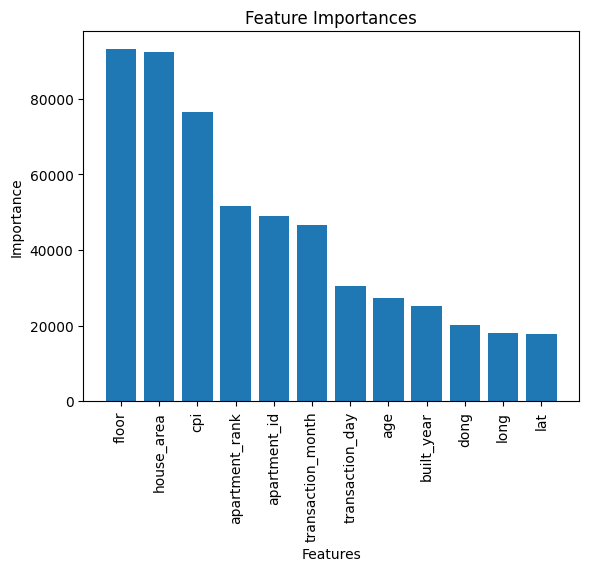

In [432]:
y_pred = gbm.predict(X_test2)

output = pd.concat([x_test3['index'], pd.DataFrame(y_pred, columns = ["PRICE"])], axis = 1)

output.to_csv('subm006.csv', index=False)  
files.download('subm006.csv')



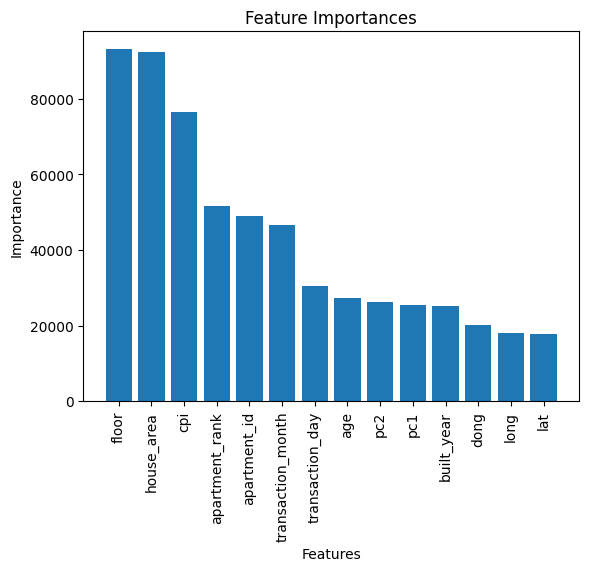

In [435]:
feat = X_test2.columns
imp = gbm.feature_importance()
plot_featimp(feat, imp)

In [434]:
X_test2

,apartment_id,dong,house_area,built_year,floor,lat,long,transaction_month,transaction_day,cpi,age,apartment_rank,pc1,pc2
0,0,197,101.647190,1993,3,35.149929,129.006071,1,5,61,30,3180.0,-5789.161862,-501.127183
1,0,197,91.511175,1993,12,35.149929,129.006071,2,1,62,30,3180.0,-5789.161862,-501.127183
2,0,197,125.865988,1993,2,35.149929,129.006071,2,0,62,30,3180.0,-5789.161862,-501.127183
3,0,197,101.647190,1993,8,35.149929,129.006071,2,2,62,30,3180.0,-5789.161862,-501.127183
4,0,197,101.647190,1993,13,35.149929,129.006071,3,5,63,30,3180.0,-5789.161862,-501.127183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,4419,37,100.821957,2014,8,37.452039,127.070842,10,5,70,9,396.0,-669.575195,-746.023601
85093,4419,37,101.431912,2014,11,37.452039,127.070842,10,5,70,9,396.0,-669.575195,-746.023601
85094,4419,37,121.201627,2014,12,37.452039,127.070842,11,1,71,9,396.0,-669.575195,-746.023601
85095,4419,37,137.192013,2014,3,37.452039,127.070842,11,4,71,9,396.0,-669.575195,-746.023601


In [393]:
# # to get the feature importance, 
# # trial 4 , removed all 'park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city' and result actually did not change
# X_train = x_train3.drop(columns = ['PRICE', 'index','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city' ])
# Y_train = x_train3['PRICE']
# X_test = x_test3.drop(columns = ['index','park_num', 'transaction_year', 'day_care_baby_num', 'DC_ratio','DC_score', 'city'])

# lgb_train = lgb.Dataset(X_train, Y_train)
# params = {
#     'n_estimators':20000
# }
# gbm = lgb.train(params, lgb_train, num_boost_round=100)

# output = pd.concat([x_test3['index'], pd.DataFrame(y_pred, columns = ["PRICE"])], axis = 1)

# output.to_csv('subm005.csv', index=False)  
# files.download('subm005.csv')

# feat = X_test.columns
# imp = gbm.feature_importance()

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 329690, number of used features: 17
[LightGBM] [Info] Start training from score 423646.758517


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

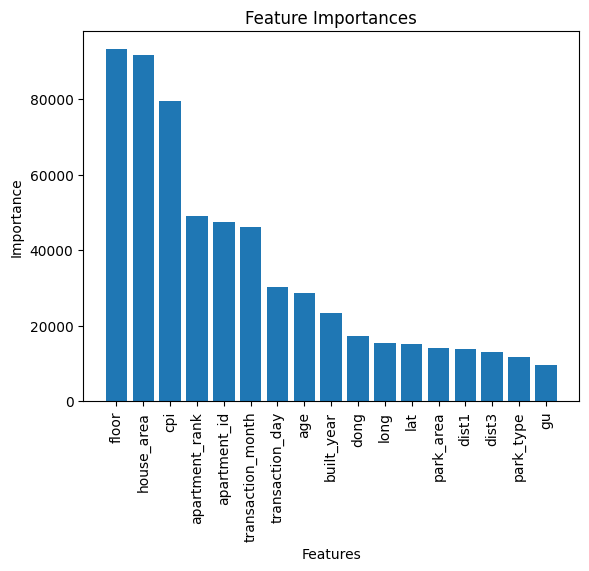

In [394]:
plot_featimp(feat, imp)

In [ ]:
lgb_train = lgb.Dataset(X_train, Y_train)
params = {
    'n_estimators':20000
}
gbm = lgb.train(params, lgb_train, num_boost_round=100)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 329690, number of used features: 23
[LightGBM] [Info] Start training from score 423646.758517


In [378]:
len(gbm.feature_importance())

23

In [379]:
y_pred = gbm.predict(X_test)


In [380]:
output = pd.concat([x_test3['index'], pd.DataFrame(y_pred, columns = ["PRICE"])], axis = 1)

output.to_csv('subm003.csv', index=False)  
files.download('subm003.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [392]:
def plot_featimp(feat, imp):
  zipped = zip(imp, feat)
  sorted1 = sorted(list(zipped))[::-1]
  feature = [x[1] for x in sorted1]
  feature_imp = [x[0] for x in sorted1]
  plt.bar(feature, feature_imp)
  plt.xlabel('Features')
  plt.ylabel('Importance')
  plt.title('Feature Importances')
  plt.xticks(rotation='vertical')
  plt.show()


In [ ]:
feat_imp = gbm.feature_importance()
feat = X_train.columns

zipped = zip(feat_imp, feat)
sorted1 = sorted(list(zipped))[::-1]
feature = [x[1] for x in sorted1]
feature_imp = [x[0] for x in sorted1]

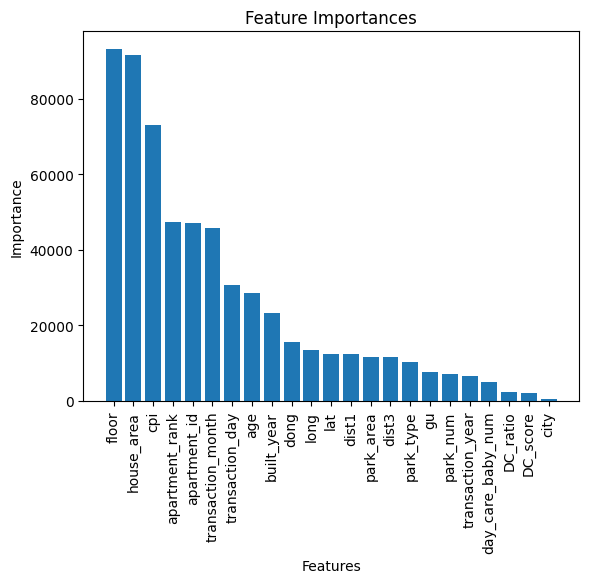

In [389]:
plt.bar(feature, feature_imp)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
cols = list(x_train3.columns)[1:]
zipped = list(zip(feat_imp, cols))
zipped.sort()
zipped

In [354]:
# y_pred8 = model_lgb11.predict(x_test3)

# output = pd.concat([x_test3['index'], pd.DataFrame(y_pred, columns = ["PRICE"])], axis = 1)

# output.to_csv('subm002.csv', index=False)  
# files.download('subm002.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [324]:
# model_lgb = lgb.LGBMRegressor(objective='regression', max_depth=7, learning_rate=0.0007953, n_estimators = 8829, min_child_samples = 85, subsample=0.5223234814923825)
# model_lgb.fit(finx_train, finy_train)
x_test3
# x_test2

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,...,apartment_rank,dist1,dist3,gu,park_type,park_area,park_num,day_care_baby_num,DC_score,DC_ratio
0,329690,0,0,197,101.647190,1993,3,35.149929,129.006071,2023,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
1,329691,0,0,197,91.511175,1993,12,35.149929,129.006071,2023,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
2,329692,0,0,197,125.865988,1993,2,35.149929,129.006071,2023,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
3,329693,0,0,197,101.647190,1993,8,35.149929,129.006071,2023,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
4,329694,0,0,197,101.647190,1993,13,35.149929,129.006071,2023,...,3180.0,0.267518,2.206177,18,0.428571,244.075200,7.0,5371,910,26.810997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86252,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329
86253,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329
86254,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329
86255,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,...,396.0,1.443422,8.650589,22,0.000000,172.214818,5.0,10522,1196,51.818329


In [323]:
# model_lgb11.feature_importance()

AttributeError: ignored

In [ ]:
# # new one
# model_lgb2 = lgb.LGBMRegressor( max_depth=7, learning_rate=0.001, n_estimators = 10000, min_child_samples = 82, subsample=0.5223234814923825)
# model_lgb2.fit(finx_train, finy_train)

# y_pred2 = model_lgb2.predict(x_test2)

# output = pd.concat([x_test2['index'], pd.DataFrame(y_pred2, columns = ["PRICE"])], axis = 1)

# output.to_csv('subm6.csv', index=False)
# files.download('subm6.csv')

In [ ]:
# model_lgb3 = lgb.LGBMRegressor( n_estimators = 10000)
# model_lgb3.fit(finx_train, finy_train)

# y_pred3 = model_lgb3.predict(x_test2)

# output = pd.concat([x_test2['index'], pd.DataFrame(y_pred3, columns = ["PRICE"])], axis = 1)

# output.to_csv('subm7.csv', index=False)  
# files.download('subm7.csv')

In [ ]:
# model_lgb4 = lgb.LGBMRegressor( )
# model_lgb4.fit(finx_train, finy_train)

In [ ]:
# model_lgb4 = lgb.LGBMRegressor()
# model_lgb4.fit(finx_train, finy_train)

# y_pred3 = model_lgb4.predict(x_test2)

# output = pd.concat([x_test2['index'], pd.DataFrame(y_pred3, columns = ["PRICE"])], axis = 1)

# output.to_csv('subm8.csv', index=False)
# files.download('subm8.csv')

In [ ]:
# model_lgb5 = lgb.LGBMRegressor(n_estimators=15000)
# model_lgb5.fit(finx_train, finy_train)

# y_pred4 = model_lgb5.predict(x_test2)

# output = pd.concat([x_test2['index'], pd.DataFrame(y_pred4, columns = ["PRICE"])], axis = 1)

# output.to_csv('subm9.csv', index=False)
# files.download('subm9.csv')

In [ ]:
# finx_train # normalizing lat and long had almost 0 effect

In [ ]:
# model_lgb

# y_pred = model_lgb.predict(x_test2)

# output = pd.concat([tst['index'], pd.DataFrame(y_pred, columns = ["PRICE"])], axis = 1)

In [ ]:
# {'max_depth': 7, 'learning_rate': 0.0007953098131062764, 'n_estimators': 8829, 'min_child_samples': 85, 'subsample': 0.5223234814923825} trial 14  value: 44711.82480833971.
# {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 8015, 'min_child_samples': 54, 'subsample': 0.8422371309477078} trial 2 with value: 47773.23330978951.
# {'max_depth': 7, 'learning_rate': 0.001023558187447401, 'n_estimators': 9524, 'min_child_samples': 82, 'subsample': 0.4785940319002228}. Best is trial 21 with value: 44231.935269501104

In [ ]:
# # subm4 was with the second hyperparameter above, it got 61k 
# model_lgb

In [ ]:
# output.to_csv('subm5.csv', index=False)
# files.download('subm5.csv')

In [ ]:
# lets try it without normalizing the lat and long
# subm 5 is without normalizing lat and long

In [ ]:
x_test2

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,cpi,age,apartment_rank,dist1,dist3
0,329690,0,0,197,101.647190,1993,3,35.149929,129.006071,2023,1,5,61,30,3180.0,0.267518,2.206177
1,329691,0,0,197,91.511175,1993,12,35.149929,129.006071,2023,2,1,62,30,3180.0,0.267518,2.206177
2,329692,0,0,197,125.865988,1993,2,35.149929,129.006071,2023,2,0,62,30,3180.0,0.267518,2.206177
3,329693,0,0,197,101.647190,1993,8,35.149929,129.006071,2023,2,2,62,30,3180.0,0.267518,2.206177
4,329694,0,0,197,101.647190,1993,13,35.149929,129.006071,2023,3,5,63,30,3180.0,0.267518,2.206177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,10,5,70,9,396.0,1.443422,8.650589
85093,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,10,5,70,9,396.0,1.443422,8.650589
85094,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,11,1,71,9,396.0,1.443422,8.650589
85095,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,11,4,71,9,396.0,1.443422,8.650589
